<a href="https://colab.research.google.com/github/arbaz52/darts-implementation/blob/master/yolo_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#links for reference
https://www.arunponnusamy.com/yolo-object-detection-opencv-python.html

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#importing the required files

In [28]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2020-01-24 07:29:52--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  16.1MB/s    in 16s     

2020-01-24 07:30:09 (14.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [29]:
!wget https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.cfg

--2020-01-24 07:30:20--  https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2020-01-24 07:30:20 (147 MB/s) - ‘yolov3.cfg’ saved [8342/8342]



In [30]:
!wget https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.txt

--2020-01-24 07:30:26--  https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 620 [text/plain]
Saving to: ‘yolov3.txt’

yolov3.txt          100%[===================>]     620  --.-KB/s    in 0s      

2020-01-24 07:30:26 (231 MB/s) - ‘yolov3.txt’ saved [620/620]



In [38]:
!wget https://i.ytimg.com/vi/ukMFR0IQ3Yc/hqdefault.jpg

--2020-01-24 07:35:47--  https://i.ytimg.com/vi/ukMFR0IQ3Yc/hqdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 108.177.119.119, 2a00:1450:4013:c00::77
Connecting to i.ytimg.com (i.ytimg.com)|108.177.119.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15724 (15K) [image/jpeg]
Saving to: ‘hqdefault.jpg’

hqdefault.jpg       100%[===================>]  15.36K  --.-KB/s    in 0s      

2020-01-24 07:35:47 (142 MB/s) - ‘hqdefault.jpg’ saved [15724/15724]



#code

In [0]:
import cv2
import numpy as np

args = {
    "image": "hqdefault.jpg",
    "weights": "yolov3.weights",
    "config" : "yolov3.cfg",
    "classes": "yolov3.txt"
}

In [0]:
# read input image
image = cv2.imread(args['image'])

Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

# read class names from text file
classes = None
with open(args['classes'], 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# generate different colors for different classes 
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# read pre-trained model and config file
net = cv2.dnn.readNet(args['weights'], args['config'])

# create input blob 
blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

# set input blob for the network
net.setInput(blob)

In [0]:
# function to get the output layer names 
# in the architecture
def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

In [0]:
# run inference through the network
# and gather predictions from output layers
outs = net.forward(get_output_layers(net))

# initialization
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4

# for each detetion from each output layer 
# get the confidence, class id, bounding box params
# and ignore weak detections (confidence < 0.5)
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])

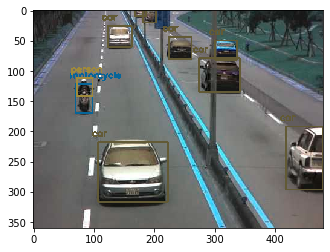

In [43]:
# apply non-max suppression
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

# go through the detections remaining
# after nms and draw bounding box
for i in indices:
    i = i[0]
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    
    draw_bounding_box(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

'''
# display output image    
cv2.imshow("object detection", image)

# wait until any key is pressed
cv2.waitKey()
    
 # save output image to disk
cv2.imwrite("object-detection.jpg", image)

# release resources
cv2.destroyAllWindows()
'''

import matplotlib.pyplot as plt
plt.imshow(image)